**Created on Jul 2019**

<strong> Author </strong>: Alexandre Yao

<h1>Use Multiple Linear Regression to predict start ups profit.</h1>

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

## Importing the dataset

In [2]:
dataset = pd.read_csv('50_Startups.csv')

In [3]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


<p>We have 50 companies. </p>

**There are 5 columns in the data,  for each company (row) we have** :

> *R&D Spend* 
>
> *Administration* : Administration spend 
>
> *Marketing Spend*
>    
> *State*: state of the company
>
> *Profit*

# Data analysis and visualization

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


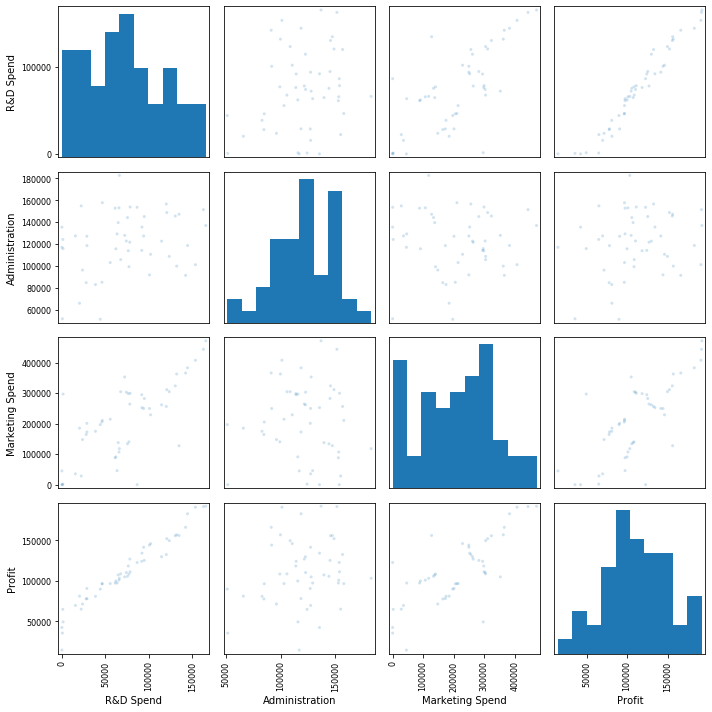

In [5]:
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1,1)
scatter_matrix(dataset, ax=ax, alpha=0.2)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [6]:
dataset.corr()

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


<p> There is a strong correlation between
R&D Spend, Marketing Spend, and Profit. We can even notice this on the graph above. <br>
These multiple correlations can be detrimental to our prediction model. We will see later how to resolve this.
</p>

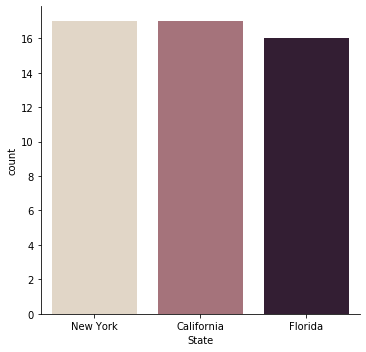

In [7]:
sns.catplot(x="State", kind="count", palette="ch:.25", data=dataset);

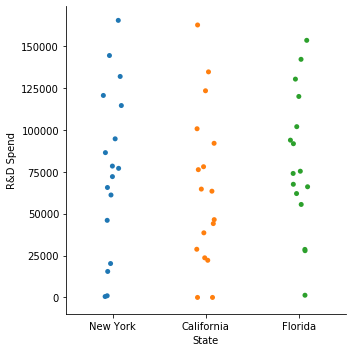

In [8]:
sns.catplot(x="State", y="R&D Spend", data=dataset);

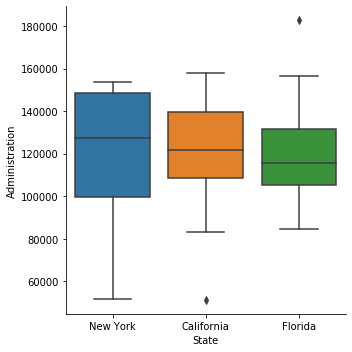

In [9]:
sns.catplot(x="State", y="Administration", kind="box", data=dataset);

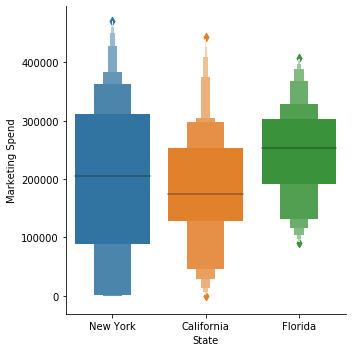

In [10]:
sns.catplot(x="State", y="Marketing Spend", kind="boxen", data=dataset);

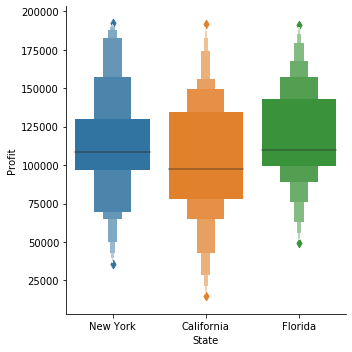

In [11]:
sns.catplot(x="State", y="Profit", kind="boxen", data=dataset);

# Multi correlations

In [12]:
from sklearn.linear_model import LinearRegression

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [13]:
sklearn_vif(dataset.columns.difference(['State']), dataset)

,VIF,Tolerance
Administration,1.182146,0.845920
Marketing Spend,2.465332,0.405625
Profit,20.302917,0.049254
R&D Spend,19.563001,0.051117


<p> The correlation between R&D Spend and Profit is even more remarkable here. Since it is the profit column that we are going to predict there is no big problem in our case. The vif method shows that the correlation between Marketing Spend and R&D Spend is not annoying </p>

# Preprocessing 

## Encoding categorical data

In [14]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

## Splitting the dataset into the Training set and Test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Modeling 

## Training the Multiple Linear Regression model on the Training set

In [16]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Predicting the Test set results

In [17]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
res = np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)

In [18]:
pd.DataFrame(res, columns=['y_pred', 'y_true'])

,y_pred,y_true
0,103015.201598,103282.38
1,132582.277608,144259.40
2,132447.738452,146121.95
3,71976.098513,77798.83
4,178537.482211,191050.39
5,116161.242302,105008.31
6,67851.692097,81229.06
7,98791.733747,97483.56
8,113969.435330,110352.25
9,167921.065696,166187.94


# Evaluate model

In [19]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
        'Root Mean Squared Error': metrics.mean_squared_error(actual, predicted)**0.5,
        'Mean Absolute Error': metrics.mean_absolute_error(actual, predicted),
        'R^2': metrics.r2_score(actual, predicted),
        'Explained Variance': metrics.explained_variance_score(actual, predicted)
    }
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [20]:
get_regression_metrics('ML regression', y_test, y_pred)

,ML regression
Root Mean Squared Error,9137.990153
Mean Absolute Error,7514.293660
R^2,0.934707
Explained Variance,0.946919
